In [1]:
from pandas.io.json import json_normalize
import json
import glob
import numpy as np
import pandas as pd
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors_old = cycler(color='bgrcmyk').by_key()['color']
saveimages = 1

In [2]:
def savefig(fig, lgd, file_name, _format):
    fig.savefig(f"./Figures/{file_name}.{_format}", bbox_inches='tight', format=_format, dpi=1200)
    
def savelegend(legend, file_name, _format):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f"./Figures/{file_name}.{_format}", dpi=1200, bbox_inches=bbox, format=_format)

In [3]:
def plot_steps(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        iteration = data.iloc[runIdx]["iteration"]
        clusters = data.iloc[runIdx]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters))
        print("iteration: %s, clusters: %s" % (iteration, len(clusters)))
        for cIdx in range(0, len(clusters)):
            rgba_color = cm.gnuplot(norm(cIdx))
            pointsX = [point[0] for point in clusters[cIdx]["points"]]
            pointsY = [point[1] for point in clusters[cIdx]["points"]]
            ax.scatter(pointsX, pointsY, color=rgba_color)
            ax.scatter(clusters[cIdx]["centroid"][0], clusters[cIdx]["centroid"][1], color=rgba_color, marker="+")

        plt.show()

In [4]:
def plot(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        clusters_step1 = data.iloc[runIdx]["steps"][0]["clusters"]
        clusters_step2 = data.iloc[runIdx]["steps"][1]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters_step1))
        for cIdx in range(0, len(clusters_step1)):
            rgba_color = cm.gnuplot(norm(cIdx))
            ax.plot(clusters_step1[cIdx]["syntheticCenter"], "--", color=rgba_color, label="cluster %s" % cIdx)
            ax.plot(clusters_step2[cIdx]["syntheticCenter"], color=rgba_color, label="cluster %s - rescheduled" % cIdx)
            print(clusters_step2[cIdx]["metric"])
        ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)

        ax.set(xlabel='Hours', ylabel='Power (kW)',title='')
        plt.show()

In [5]:
def plot_aggm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. agg m"], "--", color=rgba_color, label="s1. agg m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. agg m"], color=rgba_color, label="s2. agg m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_maxm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. max m"], "--", color=rgba_color, label="s1. max m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. max m"], color=rgba_color, label="s2. max m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Max. Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_peak(summary, file_name=None):
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. peak"], "--", color=rgba_color, label="s1. peak")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. peak"], color=rgba_color, label="s2. peak")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Peak power (kW)',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig

In [6]:
def crossfold_as_df(k, data):
    index_list = []
    step_list = []

    for i in range(0 , len(data)):
        register = data.iloc[i]

        crossfold = json_normalize(register["crossfold"])
        splits = crossfold["splits"].values[0]
        steps = data.iloc[i]["step"]
        for j in range(0, splits):
            step = json_normalize(steps[j])
            for ki in range(1, k+1):
                index_list.append((float("{0:.2f}".format(crossfold["sampleSize"].values[0])), j, ki))
                step_list.append(step.iloc[ki-1])


    json_normalize(data.iloc[0]["crossfold"])
    json_normalize(data.iloc[0]["step"][0])

    index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "split", "k"])
    return pd.DataFrame(step_list, index=index)

# PAR Aggregate

In [7]:
summaryBatch_global = pd.read_json("./files/scheduler_tests/complete_2.9c/summaryBatch.json")

exp1_splits = 200
exp1_k = 6
exp1_sample_size_min = 0.5
exp1_sample_size_max = 1.0
exp1_nsteps = 2

def sample_size_range(sample_size_min, sample_size_max):
    return (x/10 for x in range(int(sample_size_min * 10), int((sample_size_max * 10) + 1)))

In [8]:
result = []
for f in glob.glob("./files/scheduler_tests/complete_v3.0/*/*.json"):
    with open(f, "r") as infile:
        result.append(json.load(infile))

r = []
for sampleSizeIdx, sampleSize in enumerate(sample_size_range(exp1_sample_size_min, exp1_sample_size_max)):
    steps = []
    for batch in result:
        steps.append(batch[sampleSizeIdx]["step"])
        
    steps = sorted(steps, key=lambda x: x[0][0]["k"])
    
    list_of_splits = []
    for split in range(0, exp1_splits):
        list_of_split = []
        for ki in range(0, exp1_k):
            item = steps[ki].pop()
            list_of_split.append(item[0])
        #sorted(list_of_split.
        list_of_splits.append(list_of_split)
    
    r.append({"crossfold": {"splits" : 200, "sampleSize": sampleSize}, "step": list_of_splits})

with open("./files/scheduler_tests/complete_v3.0/merged_file.json", "w") as outfile:
     json.dump(r, outfile)
summaryBatch_global = pd.read_json("./files/scheduler_tests/complete_v3.0/merged_file.json")

In [9]:
exp1_treated = crossfold_as_df(exp1_k, summaryBatch_global)
k2 = 2
query = f"k == {k2} and sampleSize == {exp1_sample_size_min}"
exp1_treated.query(query)["s1. agg m"].mean()
exp1_treated.query(query)["s1. max m"].mean()
exp1_treated.query(query)["s1. peak"].std()
exp1_treated.rename(columns={"s2. total m": "s2TotalM", "s2. agg m": "s2AggM", "s2. total peak": "s2TotalPeak", "s1. total peak": "s1TotalPeak"}, inplace=True)
exp1_treated[-20:]
#exp1_treated.query("k == 6 and sampleSize == 1.0")["s2AggM"].mean()
#exp1_statistics.rename(columns={"s2. total m": "s2TotalM", "s2. agg m": "s2AggM"}, inplace=True)

k  s1. peak  s1. agg m  s1. max m  s1. total m  \
sampleSize split k                                                   
1.0        196   5  5    989058   1.023785   1.564623     1.415407   
                 6  6    901664   1.073428   1.712664     1.415407   
           197   1  1   3903617   1.415407   1.415407     1.415407   
                 2  2   3199741   1.000780   1.415805     1.415407   
                 3  3   1679879   1.011653   1.437187     1.415407   
                 4  4   1143536   1.013152   1.500250     1.415407   
                 5  5   1230010   1.044760   1.575971     1.415407   
                 6  6    778088   1.052869   1.694057     1.415407   
           198   1  1   3903617   1.415407   1.415407     1.415407   
                 2  2   1964258   1.000885   1.416652     1.415407   
                 3  3   2466886   1.014227   1.448446     1.415407   
                 4  4   1035980   1.012863   1.498274     1.415407   
                 5  5   1199732   1.056141   1.576431     1.415407   
                 6  6    806978   1.064019   1.585419     1.415407   
           199   1  1   3903617   1.415407   1.415407     1.415407   
                 2  2   2049017   1.000213   1.421925     1.415407   
                 3  3   1345603   1.005034   1.448414     1.415407   
                 4  4   1045397   1.036812   1.530130     1.415407   
                 5  5   1363023   1.037862   1.560684     1.415407   
                 6  6    839053   1.038008   1.718001     1.415407   

                    s1TotalPeak                  clusters  s2. peak    s2AggM  \
sampleSize split k                                                              
1.0        196   5      3903617      [37, 45, 32, 43, 43]    989058  1.056637   
                 6      3903617  [39, 25, 31, 40, 29, 36]    826694  1.106986   
           197   1      3903617                     [200]   3680996  1.334687   
                 2      3903617                 [152, 48]   3003428  1.339231   
                 3      3903617              [73, 65, 62]   1669192  1.020428   
                 4      3903617          [72, 44, 48, 36]   1141376  1.097024   
                 5      3903617      [30, 28, 26, 67, 49]   1187449  1.147522   
                 6      3903617  [38, 37, 21, 28, 34, 42]    754190  1.078730   
           198   1      3903617                     [200]   3680996  1.334687   
                 2      3903617                 [105, 95]   1853090  1.001348   
                 3      3903617             [116, 55, 29]   2300235  1.052546   
                 4      3903617          [43, 46, 54, 57]   1035980  1.080887   
                 5      3903617      [43, 37, 35, 39, 46]   1139492  1.060403   
                 6      3903617  [29, 28, 30, 28, 40, 45]    755195  1.057368   
           199   1      3903617                     [200]   3680996  1.334687   
                 2      3903617                 [95, 105]   1935380  1.001843   
                 3      3903617              [57, 71, 72]   1269247  1.027416   
                 4      3903617          [47, 50, 47, 56]    980443  1.060190   
                 5      3903617      [44, 31, 53, 33, 39]   1232046  1.104340   
                 6      3903617  [43, 26, 35, 27, 31, 38]    775023  1.086444   

                    s2. max m  s2TotalM  s2TotalPeak  
sampleSize split k                                    
1.0        196   5   1.564623  1.334687      3680996  
                 6   1.712664  1.336078      3684833  
           197   1   1.334687  1.334687      3680996  
                 2   2.693465  1.433640      3953904  
                 3   1.418618  1.335727      3683864  
                 4   1.493126  1.334687      3680996  
                 5   1.796558  1.339259      3693606  
                 6   1.662187  1.365901      3767084  
           198   1   1.334687  1.334687      3680996  
                 2   1.336476  1.334687      3680996  
                 3   1.537341  1.338

In [10]:
def get_statistics(k, nSteps, treated, sample_size_min, sample_size_max):
    index_list = []
    step_list = []

    for j in range(1, k+1):
        for ssize in sample_size_range(sample_size_min, sample_size_max):

            index_list.append((ssize, "mean", j))
            query = f"k == {j} and sampleSize == {ssize}"
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
            data = {key: treated.query(query)[key].mean() for key in index}
            data = {"s1. agg m" : treated.query(query)["s1. agg m"].mean(),
                    "s1. max m" : treated.query(query)["s1. max m"].mean(), 
                    "s1. peak" : treated.query(query)["s1. peak"].mean()/1000,
                   "s1. total m" : treated.query(query)["s1. total m"].mean(),
                   "s1TotalPeak" : treated.query(query)["s1TotalPeak"].mean()/1000}
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m", "s1TotalPeak"]
            if (nSteps >= 2):
                data.update({"s2AggM" : treated.query(query)["s2AggM"].mean(),
                    "s2. max m" : treated.query(query)["s2. max m"].mean(), 
                    "s2. peak" : treated.query(query)["s2. peak"].mean()/1000,
                    "s2TotalM" : treated.query(query)["s2TotalM"].mean(),
                    "s2TotalPeak" : treated.query(query)["s2TotalPeak"].mean()/1000})
                index = index + ["s2AggM","s2. max m","s2. peak", "s2TotalM", "s2TotalPeak"]

            s = pd.Series(data,index=index) 
            step_list.append(s)
            #print(f"sampleSize = {ssize}, k = {j}")

            index_list.append((ssize, "stdv", j))
            query = f"k == {j} and sampleSize == {ssize}"
            data = {"s1. agg m" : treated.query(query)["s1. agg m"].std(),
                    "s1. max m" : treated.query(query)["s1. max m"].std(), 
                    "s1. peak" : treated.query(query)["s1. peak"].std(),
                   "s1. total m" : treated.query(query)["s1. total m"].std(),
                   "s1TotalPeak" : treated.query(query)["s1TotalPeak"].std()}
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m", "s1TotalPeak"]
            if (nSteps >= 2):
                data.update({"s2AggM" : treated.query(query)["s2AggM"].std(),
                    "s2. max m" : treated.query(query)["s2. max m"].std(), 
                    "s2. peak" : treated.query(query)["s2. peak"].std(),
                            "s2TotalM" : treated.query(query)["s2TotalM"].std(),
                            "s2TotalPeak" : treated.query(query)["s2TotalPeak"].std()})
                index = index + ["s2AggM","s2. max m","s2. peak", "s2TotalM", "s2TotalPeak"]

            s = pd.Series(data,index=index) 
            step_list.append(s)


    index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "metric", "k"])
    return pd.DataFrame(step_list, index=index)
exp1_statistics = get_statistics(exp1_k,exp1_nsteps, exp1_treated, exp1_sample_size_min, exp1_sample_size_max)
exp1_statistics

s1. agg m  s1. max m       s1. peak   s1. total m  \
sampleSize metric k                                                      
0.5        mean   1   1.500762   1.500762    2063.735365  1.500762e+00   
           stdv   1   0.121221   0.121221  171638.403074  1.212206e-01   
0.6        mean   1   1.456958   1.456958    2419.234245  1.456958e+00   
           stdv   1   0.081973   0.081973  142694.045289  8.197259e-02   
0.7        mean   1   1.446043   1.446043    2777.672125  1.446043e+00   
...                        ...        ...            ...           ...   
0.8        stdv   6   0.022988   0.098981  188619.636938  6.643999e-02   
0.9        mean   6   1.054711   1.688501     888.716290  1.425563e+00   
           stdv   6   0.015497   0.067033  181579.468691  5.086217e-02   
1.0        mean   6   1.048409   1.665922     914.211485  1.415407e+00   
           stdv   6   0.015514   0.054075  150691.004828  4.452036e-16   

                       s1TotalPeak    s2AggM  s2. max m       s2. peak  \
sampleSize metric k                                                      
0.5        mean   1    2063.735365  1.439761   1.439761    1983.417950   
           stdv   1  171638.403074  0.108483   0.108483  199512.286414   
0.6        mean   1    2419.234245  1.393998   1.393998    2317.222130   
           stdv   1  142694.045289  0.072787   0.072787  170262.589036   
0.7        mean   1    2777.672125  1.377094   1.377094    2646.950815   
...                            ...       ...        ...            ...   
0.8        stdv   6   92573.855846  0.037279   0.129569  185375.848791   
0.9        mean   6    3522.813230  1.095884   1.703696     847.723450   
           stdv   6   73142.476527  0.057297   0.157534  167766.686498   
1.0        mean   6    3903.617000  1.075527   1.650581     871.170180   
           stdv   6       0.000000  0.023276   0.066631  137479.235719   

                     s2TotalM    s2TotalPeak  
sampleSize metric k                           
0.5        mean   1  1.439761    1983.417950  
           stdv   1  0.108483  199512.286414  
0.6        mean   1  1.393998    2317.222130  
           stdv   1  0.072787  170262.589036  
0.7        mean   1  1.377094    2646.950815  
...                       ...            ...  
0.8        stdv   6  0.055011  115169.515739  
0.9        mean   6  1.367837    3380.851130  
           stdv   6  0.042653   79213.643344  
1.0        mean   6  1.353459    3732.769730  
           stdv   6  0.019944   55005.129037  

[72 rows x 10 columns]

In [11]:
def get_metrics(k, metric, metric_type, statistics, sample_size_min, sample_size_max):

    index_list = [sample_size_range(sample_size_min, sample_size_max)]
    cols = [x for x in range(1, k+1)]
    step_list = []

    for ssize in sample_size_range(sample_size_min, sample_size_max):
        query = f"sampleSize == {ssize} and metric == \"{metric_type}\" "
        dataAllK = statistics.query(query)[f"{metric}"]
        dictAllK = {}
        for j in range(1, k+1):
            d = dataAllK.reset_index().query(f"k == {j}")[f"{metric}"]
            dictAllK[f"{j}"] = d.values[0]
        s = pd.Series(dictAllK, name=f"{ssize}")
        step_list.append(s)

    return pd.DataFrame(step_list)
    

In [12]:
mname = "s2TotalM"
mtype = "mean"
s2_total_m = get_metrics(exp1_k, mname, mtype, exp1_statistics, exp1_sample_size_min, exp1_sample_size_max)
s2_total_m

,1,2,3,4,5,6
0.5,1.439761,1.445603,1.431924,1.436692,1.439836,1.436410
0.6,1.393998,1.417682,1.408722,1.411412,1.424363,1.419930
0.7,1.377094,1.393561,1.389571,1.395435,1.393823,1.396747
0.8,1.344665,1.376308,1.376656,1.377275,1.378864,1.378913
0.9,1.339058,1.369501,1.355453,1.363248,1.362992,1.367837
1.0,1.334687,1.351870,1.350045,1.353713,1.355739,1.353459


In [13]:
mname = "s1. total m"
mtype = "mean"
s1_total_m = get_metrics(exp1_k, mname, mtype, exp1_statistics, exp1_sample_size_min, exp1_sample_size_max)
s1_total_m

,1,2,3,4,5,6
0.5,1.500762,1.495583,1.473439,1.477190,1.498334,1.479669
0.6,1.456958,1.453457,1.457915,1.458013,1.463289,1.458983
0.7,1.446043,1.436064,1.433931,1.438481,1.434155,1.441083
0.8,1.412760,1.414611,1.424121,1.420347,1.424301,1.426235
0.9,1.415152,1.417050,1.409602,1.417883,1.413626,1.425563
1.0,1.415407,1.415407,1.415407,1.415407,1.415407,1.415407


In [14]:
s1_total_m["1"].values

array([1.50076179, 1.45695816, 1.44604282, 1.41275965, 1.41515234,
       1.41540665])

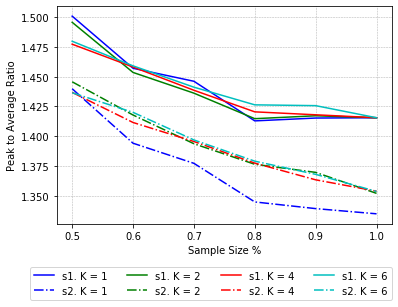

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [23]:
improvement_ratio = {"k1": [], "k2": [], "k4": [], "k6": [], "sampleSizes": []}

fig, ax = plt.subplots()

k2 = 1
sampleMaxMDataset = s1_total_m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values_1 = sampleMaxMDataset.values
ax.plot(sampleSizes, values_1, "-", label=f"s1. K = {k2}", c=colors_old[0])

sampleMaxMDataset = s2_total_m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values_2 = sampleMaxMDataset.values
ax.plot(sampleSizes, values_2, "-.", label=f"s2. K = {k2}", c=colors_old[0])

k2 = 2
sampleMaxMDataset = s1_total_m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values_1 = sampleMaxMDataset.values
ax.plot(sampleSizes, values_1, "-", label=f"s1. K = {k2}", c=colors_old[1])

sampleMaxMDataset = s2_total_m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values_2 = sampleMaxMDataset.values
ax.plot(sampleSizes, values_2, "-.", label=f"s2. K = {k2}", c=colors_old[1])

k2 = 4
sampleMaxMDataset = s1_total_m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values_1 = sampleMaxMDataset.values
ax.plot(sampleSizes, values_1, "-", label=f"s1. K = {k2}", c=colors_old[2])

sampleMaxMDataset = s2_total_m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values_2 = sampleMaxMDataset.values
ax.plot(sampleSizes, values_2, "-.", label=f"s2. K = {k2}", c=colors_old[2])

k2 = 6
sampleMaxMDataset = s1_total_m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values_1 = sampleMaxMDataset.values
ax.plot(sampleSizes, values_1, "-", label=f"s1. K = {k2}", c=colors_old[3])

sampleMaxMDataset = s2_total_m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values_2 = sampleMaxMDataset.values
ax.plot(sampleSizes, values_2, "-.", label=f"s2. K = {k2}", c=colors_old[3])

ax.tick_params(axis='x', which='major')
lgd = ax.legend(bbox_to_anchor=(1, -0.35), loc=4, borderaxespad=0., mode=None, ncol=4)
ax.set(xlabel='Sample Size %', ylabel='Peak to Average Ratio',title='')
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', linewidth='0.5')
plt.show()
if saveimages == 1:
    file_name = "peaktoaverageratio_samplesize"
    if file_name is not None:
        savefig(fig, lgd, file_name, "pdf")
        savefig(fig, lgd, file_name, "eps")

3.197209758746223
3.1966053768147553


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

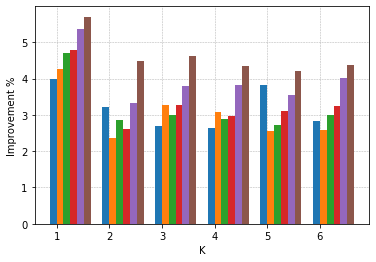

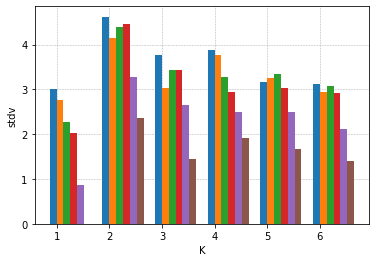

In [16]:
def improvement_ratio(x):
    return list(map(lambda xy: (1 - xy[0]/xy[1]) * 100,zip(x["s2TotalM"], x["s1. total m"])))

data = exp1_treated.groupby("sampleSize").apply(improvement_ratio).to_frame().reset_index()
print(np.array(data[data["sampleSize"] == 0.7][0].values[0]).mean())
print(np.array(data[0][0]).mean())
data[0] = data[0].apply(lambda x: np.array(x).mean())
data

#fig, ax = plt.subplots()

#ax.plot(data["sampleSize"].values, data[0].values, "-", label=f"Imp. ratio K = {k2}")

exp1_improvement_ratio_df = exp1_treated.copy()
exp1_improvement_ratio_df.drop("k",axis=1,inplace=True)

exp1_improvement_ratio_df_grouped = exp1_improvement_ratio_df.groupby(["sampleSize", 'k']).apply(improvement_ratio).to_frame().reset_index()
exp1_improvement_ratio_df_grouped.rename(columns={0: "values"},inplace=True)
exp1_improvement_ratio_df_grouped["mean"] = exp1_improvement_ratio_df_grouped["values"].apply(lambda x: np.array(x).mean())
exp1_improvement_ratio_df_grouped["stdv"] = exp1_improvement_ratio_df_grouped["values"].apply(lambda x: np.array(x).std())
exp1_improvement_ratio_df_grouped


fig_mean, ax_mean = plt.subplots()
fig_stdv, ax_stdv = plt.subplots()
ax_mean.set_axisbelow(True)
ax_stdv.set_axisbelow(True)



#fig.set_size_inches(17.0, 10.5)
#ax.set_ylim(0.9,1.02)
ind = np.arange(6)    # the x locations for the groups
width = 0.13        # the width of the bars

bars = []

for idx, ssize in enumerate(sample_size_range(exp1_sample_size_min, exp1_sample_size_max)):
    sample_size_batch = exp1_improvement_ratio_df_grouped.query(f"sampleSize == {ssize}")
    means = sample_size_batch["mean"]
    stdvs = sample_size_batch["stdv"]
    ax_mean.bar(ind + idx*width, means, width, yerr=None, label=str(ssize), color=colors[idx])
    ax_stdv.bar(ind + idx*width, stdvs, width, yerr=None, label=str(ssize), color=colors[idx])


ax_mean.set_xticks(ind + width / 2)
ax_mean.set_xticklabels(('1', '2', '3', '4', '5', '6'))
ax_mean.set_ylabel('Improvement %')
ax_mean.set_xlabel('K')
lgd_mean = ax_mean.legend(title="Sample Size %", bbox_to_anchor=(1, -0.40), loc=4, borderaxespad=0., ncol=3)

ax_stdv.set_xticks(ind + width / 2)
ax_stdv.set_xticklabels(('1', '2', '3', '4', '5', '6'))
ax_stdv.set_ylabel('stdv')
ax_stdv.set_xlabel('K')
lgd_stdv = ax_stdv.legend(title="Sample Size %", bbox_to_anchor=(1, -0.40), loc=4, borderaxespad=0., ncol=3)

ax_mean.grid(True, linestyle='--', linewidth='0.5')
ax_stdv.grid(True, linestyle='--', linewidth='0.5')

if saveimages == 1:
    file_name_mean = "s1_s2_improvement_mean"
    file_name_stdv = "s1_s2_improvement_stdv"
    file_name_legend = "samplesize_legend"

    savelegend(lgd_mean, file_name_legend, "pdf")
    savelegend(lgd_mean, file_name_legend, "eps")

    savefig(fig_mean, lgd_mean, file_name_mean, "pdf")
    savefig(fig_mean, lgd_mean, file_name_mean, "eps")

    lgd_mean.remove()
    savefig(fig_mean, None, file_name_mean + "_no_legend", "pdf")
    savefig(fig_mean, None, file_name_mean + "_no_legend", "eps")

    savefig(fig_stdv, lgd_stdv, file_name_stdv, "pdf")
    savefig(fig_stdv, lgd_stdv, file_name_stdv, "eps")

    lgd_stdv.remove()
    savefig(fig_stdv, None, file_name_stdv + "_no_legend", "pdf")
    savefig(fig_stdv, None, file_name_stdv + "_no_legend", "eps")



#exp1_improvement_ratio_df_grouped



In [17]:
def show_summary2(k, summary_treated, statistics, sample_size):
    _list_clusters = {}
    _list_max_toal_m = {}
    _list_min_toal_m = {}
    _list_above_s1agg_m = {}
    _list_below_s1agg_m = {}
    rows_per_k = summary_treated.query(f"sampleSize == {sample_size} and k == 1").reset_index(drop=True).count().iloc[0]
    k1_s1_agg_m = statistics.query(f"sampleSize == {sample_size} and metric == \"mean\" and k == 1").reset_index().drop(["sampleSize", "metric"], axis=1)["s1. agg m"]
    
    for j in range(1, k+1):
        _list_clusters[j - 1] = str(summary_treated.query(f"sampleSize == {sample_size} and k == {j}").sort_values(by=["s1. max m", "s1. agg m"]).iloc[0]["clusters"])
        _list_max_toal_m[j - 1] = summary_treated.query(f"sampleSize == {sample_size} and k == {j}").sort_values(by=["s2TotalM"],ascending=False).iloc[0]["s2TotalM"]
        _list_min_toal_m[j - 1] = summary_treated.query(f"sampleSize == {sample_size} and k == {j}").sort_values(by=["s2TotalM"],ascending=True).iloc[0]["s2TotalM"]
        _list_above_s1agg_m[j - 1] = summary_treated.query(f"sampleSize == {sample_size} and s2TotalM >= {k1_s1_agg_m.values[0]} and k == {j}").reset_index(drop=True).count().iloc[0] / rows_per_k
        _list_below_s1agg_m[j - 1] = summary_treated.query(f"sampleSize == {sample_size} and s2TotalM < {k1_s1_agg_m.values[0]} and k == {j}").reset_index(drop=True).count().iloc[0] / rows_per_k
    a = statistics.query(f"sampleSize == {sample_size} and metric == \"mean\"").reset_index().drop(["sampleSize", "metric"], axis=1)
    b = pd.DataFrame.from_dict(_list_clusters, orient="index", columns=["clusters"])
    c = pd.DataFrame.from_dict(_list_max_toal_m, orient="index", columns=["s2. total max m"])
    d = pd.DataFrame.from_dict(_list_min_toal_m, orient="index", columns=["s2. total min m"])
    e = pd.DataFrame.from_dict(_list_above_s1agg_m, orient="index", columns=["s2TotalAboveM"])
    f = pd.DataFrame.from_dict(_list_below_s1agg_m, orient="index", columns=["s2TotalBelowM"])
    r = pd.concat([a,b,c,d,e,f], axis=1, sort=False)
    #r = r[["k", "s1. agg m", "s1. max m", "s1. peak", "s2AggM", "s2. max m", "s2. peak", "s2TotalM", "s2. total max m", "s2. total min m", "s2TotalBelowN"]]
    return r

r = show_summary2(exp1_k, exp1_treated, exp1_statistics, '1.0')
k1_s1_agg_m = exp1_statistics.query("sampleSize == 1.0 and metric == \"mean\" and k == 1").reset_index().drop(["sampleSize", "metric"], axis=1)["s1. agg m"]
exp1_treated.query(f"sampleSize == 1.0 and s2TotalM > {k1_s1_agg_m.values[0]} and k == 4").reset_index(drop=True).count().iloc[0]
#r1 = exp1_treated_copy.query("sampleSize == 1.0").reset_index().drop(["sampleSize", "metric"], axis=1)
#r1
r


,k,s1. agg m,s1. max m,s1. peak,s1. total m,s1TotalPeak,s2AggM,s2. max m,s2. peak,s2TotalM,s2TotalPeak,clusters,s2. total max m,s2. total min m,s2TotalAboveM,s2TotalBelowM
0,1,1.415407,1.415407,3903.617000,1.415407,3903.617,1.334687,1.334687,3680.996000,1.334687,3680.996000,[200],1.334687,1.334687,0.000,1.000
1,2,1.000856,1.418063,2359.886850,1.415407,3903.617,1.071683,1.567520,2238.295730,1.351870,3728.386045,"[120, 80]",1.510731,1.334687,0.075,0.925
2,3,1.008079,1.455458,1670.682055,1.415407,3903.617,1.070385,1.551325,1595.357775,1.350045,3723.353550,"[51, 39, 110]",1.428372,1.334687,0.015,0.985
3,4,1.023398,1.515071,1269.706590,1.415407,3903.617,1.063562,1.536380,1213.810625,1.353713,3733.470160,"[67, 49, 45, 39]",1.469467,1.334687,0.025,0.975
4,5,1.038327,1.589961,1098.575060,1.415407,3903.617,1.068384,1.587189,1043.863475,1.355739,3739.056650,"[33, 42, 41, 44, 40]",1.451049,1.334687,0.025,0.975
5,6,1.048409,1.665922,914.211485,1.415407,3903.617,1.075527,1.650581,871.170180,1.353459,3732.769730,"[35, 24, 30, 34, 40, 37]",1.445670,1.334687,0.010,0.990


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

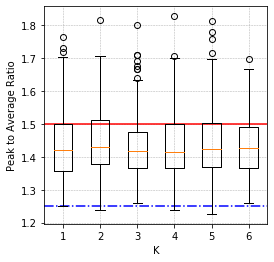

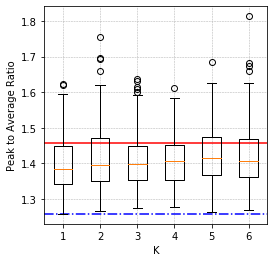

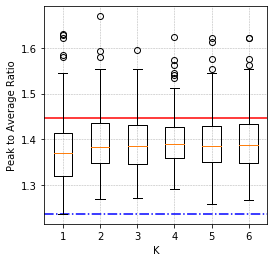

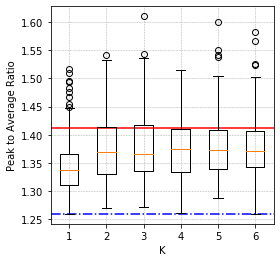

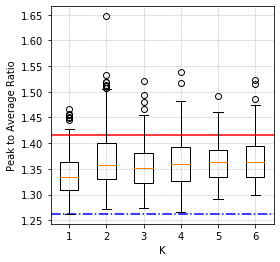

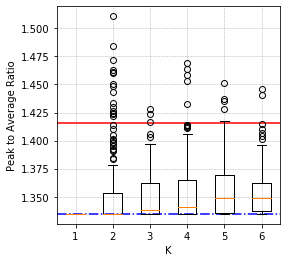

In [18]:
def boxplot_samplesize_par(sample_size):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='--', linewidth='0.5')
    exp1_summary = show_summary2(exp1_k, exp1_treated, exp1_statistics, sample_size)
    k1_s1_agg_m = exp1_summary.query("k == 1").reset_index()["s1. max m"]
    k1_s2_agg_m = exp1_summary.query("k == 1").reset_index()["s2. total min m"]

    data = [exp1_treated.query(f"sampleSize == {sample_size} and k == {i}")["s2TotalM"].values for i in range(1,7)]

    plt.axhline(y=k1_s1_agg_m.values[0], color='r', linestyle='-', label=f"s1. PAR for K = 1")
    plt.axhline(y=k1_s2_agg_m.values[0], color='b', linestyle='-.', label=f"s2. PAR for K = 1")
    ax.boxplot(data,labels=[1,2,3,4,5,6])

    lgd = ax.legend(bbox_to_anchor=(1, -0.45), loc=4, borderaxespad=0.)
    ax.set(xlabel='K', ylabel='Peak to Average Ratio',title='')
    return (fig, ax, lgd)


if saveimages == 1:
    for ssize in sample_size_range(exp1_sample_size_min, exp1_sample_size_max):
        fig, ax, lgd = boxplot_samplesize_par(ssize)
        savelegend(lgd, f"boxplot_samplesize_par_legend", "pdf")
        savelegend(lgd, f"boxplot_samplesize_par_legend", "eps")
        savefig(fig, lgd, f"boxplot_samplesize_par_{int(ssize*100)}_no_legend", "pdf")
        savefig(fig, lgd, f"boxplot_samplesize_par_{int(ssize*100)}_no_legend", "eps")
        lgd.remove()
        savefig(fig, lgd, f"boxplot_samplesize_par_{int(ssize*100)}_no_legend", "pdf")
        savefig(fig, lgd, f"boxplot_samplesize_par_{int(ssize*100)}_no_legend", "eps")


1.4154066514685684

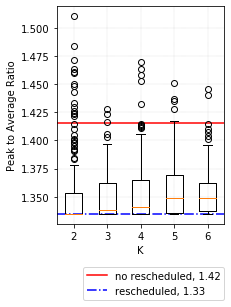

In [19]:
sampleSize = 1.0
fig, ax = plt.subplots(figsize=(3, 4))
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', linewidth='0.2')
exp1_summary = show_summary2(exp1_k, exp1_treated, exp1_statistics, sampleSize)
k1_s1_agg_m = exp1_summary.query("k == 1").reset_index()["s1. max m"]
k1_s2_agg_m = exp1_summary.query("k == 1").reset_index()["s2. total min m"]

data = [exp1_treated.query(f"sampleSize == {sampleSize} and k == {i}")["s2TotalM"].values for i in range(2,7)]

plt.axhline(y=k1_s1_agg_m.values[0], color='r', linestyle='-', label=f"no rescheduled, {round(k1_s1_agg_m.values[0], 2)}")
plt.axhline(y=k1_s2_agg_m.values[0], color='b', linestyle='-.', label=f"rescheduled, {round(k1_s2_agg_m.values[0], 2)}")
ax.boxplot(data,labels=[2,3,4,5,6])

lgd = ax.legend(bbox_to_anchor=(1, -0.35), loc=4, borderaxespad=0.)
ax.set(xlabel='K', ylabel='Peak to Average Ratio',title='')

#exp1_treated.query("sampleSize == 1.0 and k == 6")["s2TotalM"].values
k1_s1_agg_m.values[0]

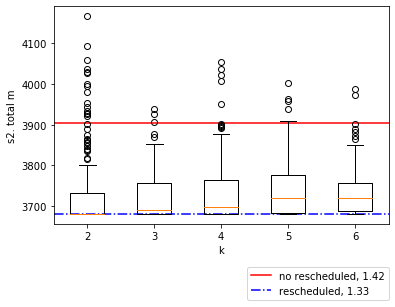

In [20]:
sampleSize = 1.0
fig, ax = plt.subplots()
exp1_summary = show_summary2(exp1_k, exp1_treated, exp1_statistics, sampleSize)
k1_s1_total_peak = exp1_summary.query("k == 1").reset_index()["s1TotalPeak"]
k1_s2_total_peak = exp1_summary.query("k == 1").reset_index()["s2TotalPeak"]

data = [exp1_treated.query(f"sampleSize == {sampleSize} and k == {i}")["s2TotalPeak"].values for i in range(2,7)]

plt.axhline(y=k1_s1_total_peak.values[0], color='r', linestyle='-', label=f"no rescheduled, {round(k1_s1_agg_m.values[0], 2)}")
plt.axhline(y=k1_s2_total_peak.values[0], color='b', linestyle='-.', label=f"rescheduled, {round(k1_s2_agg_m.values[0], 2)}")
ax.boxplot(list(map(lambda x: x/1000, data)),labels=[2,3,4,5,6])

lgd = ax.legend(bbox_to_anchor=(1, -0.35), loc=4, borderaxespad=0.)
ax.set(xlabel='k', ylabel='s2. total m',title='')

#exp1_treated.query("sampleSize == 1.0 and k == 6")["s2TotalM"].values
plt.show()

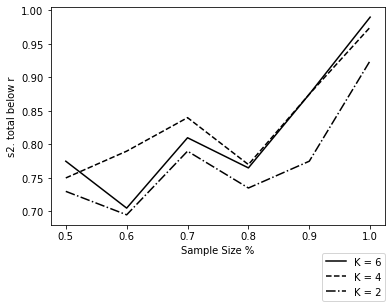

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [21]:
_list = []
for ssize in sample_size_range(exp1_sample_size_min, exp1_sample_size_max):
    res = show_summary2(exp1_k, exp1_treated, exp1_statistics, ssize)
    res["sampleSize"] = ssize
    _list.append(res)
exp1_total_below_m = pd.concat(_list)

fig, ax = plt.subplots()

k2 = 6
sampleMaxMDataset = exp1_total_below_m.query(f"k == {k2}")
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset["sampleSize"].values))
values = sampleMaxMDataset["s2TotalBelowM"].values
ax.plot(sampleSizes, values, "-", label=f"K = {k2}", c="black")

k2 = 4
sampleMaxMDataset = exp1_total_below_m.query(f"k == {k2}")
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset["sampleSize"].values))
values = sampleMaxMDataset["s2TotalBelowM"].values
ax.plot(sampleSizes, values, "--", label=f"K = {k2}", c="black")

k2 = 2
sampleMaxMDataset = exp1_total_below_m.query(f"k == {k2}")
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset["sampleSize"].values))
values = sampleMaxMDataset["s2TotalBelowM"].values
ax.plot(sampleSizes, values, "-.", label=f"K = {k2}", c="black")

lgd = ax.legend(bbox_to_anchor=(1, -0.35), loc=4, borderaxespad=0.)
ax.set(xlabel='Sample Size %', ylabel='s2. total below r',title='')
plt.show()
file_name = "s2TotalBelowM_sampleSize"
if file_name is not None:
    fig.savefig(f"{file_name}.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight', format="pdf", dpi=1200)
    fig.savefig(f"{file_name}.eps", bbox_extra_artists=(lgd,), bbox_inches='tight', format="eps", dpi=1200)